In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os, sys, time
import matplotlib.pyplot as plt
%matplotlib inline

print("Current environment directory:" + sys.prefix)
print("System version: "+sys.version)
print("Current working directory: "+os.getcwd())

Current environment directory:/Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python/env/bin/..
System version: 2.7.12 (default, Aug 23 2016, 08:54:23) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
Current working directory: /Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python


In [34]:
# Load the true incidence matrix 

A_full = np.matrix(np.genfromtxt('../../Data/MatlabData/A_complete_true_13bus.csv', dtype=int,delimiter=',')) # l x n
A = np.matrix(np.genfromtxt('../../Data/MatlabData/A_true_13bus.csv', dtype=int,delimiter=','))  # l x n
abs_incidence = np.abs(A)

# Because we have a directed incidence matrix, A.T * A is actually the Laplacian!

B = np.matrix(np.genfromtxt('../../Data/MatlabData/B_true_13bus.csv', delimiter=','))  # n x n
D = np.matrix(np.genfromtxt('../../Data/MatlabData/D_true_13bus.csv', delimiter=','))  # l x l

/Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python/env/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python/env/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python/env/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/User

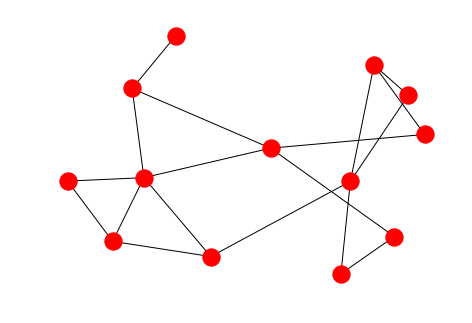

In [3]:
adj = np.dot(abs_incidence.T,abs_incidence)
np.fill_diagonal(adj,0)
G = nx.from_numpy_matrix(adj)
np.random.seed(1)  # The non-circular graphing tools position nodes randomly. This makes it repeatable.

nx.draw_spring(G)

In [60]:
# Reconstructing network from B:

# Compute the missing vertices by subtracting sum from diagonal

# Loop through the lower part of the network, and wherever there is a non-zero entry we populate the A matrix with a 1
#  and add the weight to the list of weights

B = np.matrix(np.genfromtxt('../../Data/MatlabData/B_true_13bus.csv', delimiter=','))  # n x n

threshold = 0.001
n = B.shape[0]
diag = B.diagonal()
delta = np.asarray( B.sum(axis=0) ).reshape( B.shape[0] )  # Results in a 1-d np.ndarray
right_mat = np.vstack( (np.zeros([1,n]),B) )
B_complete = np.hstack( (np.zeros([n+1,1]),right_mat) )
B_complete[0:5,0:5]

## Create the augmented B-matrix, including reference bus ###
for i in range(B.shape[0]):
    if abs(delta[i]) > threshold: # We want to include a new entry in B_complete
        print("Diff at entry %s"%i)
        B_complete[0,i+1] = -1 * delta[i]
        B_complete[i+1,0] = -1 * delta[i]

# Now complete the B-matrix diagonal entry:
B_complete[0,0] = -1 * B_complete[:,0].sum()

matrix([[  0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
        [  0.    ,  33.374 ,  -5.0513,  -5.6715,  -5.7511],
        [  0.    ,  -5.0513,  10.898 ,  -5.8469,   0.    ],
        [  0.    ,  -5.6715,  -5.8469,  42.011 , -23.747 ],
        [  0.    ,  -5.7511,   0.    , -23.747 ,  38.239 ]])

In [93]:
### Create A-matrix and D-matrix
lowerTri = B_complete
np.fill_diagonal(lowerTri,0)
lowerTri = np.tril(lowerTri)

lineCount = (np.abs(lowerTri) > threshold).sum()

D_guess = np.zeros(lineCount)
A_guess = np.zeros([lineCount,n+1],'int')

lineCounter = 0

for j in range(n+1):
    for i in range(n+1):
        if lowerTri[i,j] < -threshold:
            D_guess[lineCounter] = -lowerTri[i,j]
            A_guess[lineCounter,i] = 1
            A_guess[lineCounter,j] = 1
            lineCounter += 1

# # This has now fully reconstructed the A-matrix and D-vector from our estimates, as the following code can verify
# print(A_guess.sum(axis=0))
# print(np.abs(A_full).sum(axis=0))
# np.abs(A_full) == A_guess